## Source sensitivity d


\begin{equation}
    {\color{blue} {r_2(d;F, \Omega, \boldsymbol{x})}}
    \equiv \frac{p(d = 1| F, \Omega, \boldsymbol{x})}
    {p(d=1)}
\end{equation}

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft
import swyft.lightning as sl
import sims
from networks import NetworkMaps, NetworkSensitivity
import math

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from icecream import ic
plt.style.use(['science', 'notebook'])

### Simulator that incorporates r_1 to estimate d

Load back sensitivity maps network

In [3]:
simulator = sims.ToyFermi(npix = 128)
shapes, dtypes = simulator.get_shapes_and_dtypes()
store = swyft.ZarrStore("/project/fermi_data/neurips_original.zarr").init(50000, 64, shapes, dtypes)
dl_val = store.get_dataloader(idx_range = [36000, 40000], batch_size = 32, num_workers = 8)

trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1)
ckpt_path = swyft.best_from_yaml("./lightning_logs/neurips_detection/version_0/checkpoints/model.yaml")
print(ckpt_path)
network_maps = NetworkMaps()
trainer.test(network_maps, dl_val, ckpt_path = ckpt_path);

/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Restoring states from the checkpoint path at ./lightning_logs/neurips_detection/version_0/checkpoints/epoch=34-val_loss=-1090.87.ckpt


./lightning_logs/neurips_detection/version_0/checkpoints/epoch=34-val_loss=-1090.87.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_detection/version_0/checkpoints/epoch=34-val_loss=-1090.87.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -1085.1932373046875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Simulate with d based on r_1

In [4]:
simulator = sims.ToyFermi_d(npix=128, network_maps=network_maps)
shapes, dtypes = simulator.get_shapes_and_dtypes()
zs = swyft.ZarrStore("/project/fermi_data/neurips_original_d.zarr").init(100000, 64, shapes, dtypes)
zs.simulate(simulator, batch_size = 500)

/home/noemiam/fermi/neurips22/fermi/sims.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(pdcc[:, :2])
/home/noemiam/fermi/neurips22/fermi/sims.py:248: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(pdcc[:, 2])


Trick idx index for training on single point source

In [5]:
def hook(out, test=False, d=1.):
    N = int(out['pdp'][0])
    idx = torch.randint(N, (1,)) # index in simulated source range
    out['source'] = torch.from_numpy(out['pdc'][idx]).clone() # (3,)
    
    # make sure to pick source simulated in image
    while torch.sum((out['source'][:2]>40)+(out['source'][:2]<-40), -1):
        idx = torch.randint(N, (1,)) # index in simulated source range
        out['source'] = torch.from_numpy(out['pdc'][idx]) # (3,)
        
    out['source'][2] = np.log10(out['source'][2]) # use log10(F)
    
    if test:
        out['d_source'] = np.array([d]) # trick label into being always d=1, we want to estimate p(d=1| F...)
    else:
        out['d_source'] = np.array([out['d'][idx]])*1. # (1,)   
    
        # TO DO: check code in sims.detection_d
        if out['source'][2] > 2:
            out['d_source'] = np.array([1.])
        
    out = sl.to_numpy32(out)
    return out

dl_train = zs.get_dataloader(idx_range = [1, 36000], batch_size = 32, num_workers = 8, on_after_load_sample = hook)
dl_val = zs.get_dataloader(idx_range = [36000, 40000], batch_size = 32, num_workers = 8, on_after_load_sample = hook)

Train

In [6]:
logger = TensorBoardLogger("./lightning_logs", name = 'neurips_sensitivity', version=None)
checkpoint_callback = ModelCheckpoint(monitor="val_loss", filename="{epoch:02d}-{val_loss:.2f}", save_top_k=1, mode="min",)

trainer = swyft.SwyftTrainer(
    accelerator = 'gpu', 
    gpus=1, 
    max_epochs = 100, 
    logger = logger, 
    callbacks = [checkpoint_callback]
)
network_d = NetworkSensitivity(lr=1e-3, lrs_factor = 0.1, lrs_patience = 3, early_stopping_patience = 5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
# trainer.fit(network_d, train_dataloaders = dl_train, val_dataloaders = dl_val)

In [8]:
# checkpoint_callback.to_yaml(checkpoint_callback.dirpath+"/model.yaml")
# ckpt_path = swyft.best_from_yaml(checkpoint_callback.dirpath+"/model.yaml")
ckpt_path = swyft.best_from_yaml("./lightning_logs/neurips_sensitivity/version_0/checkpoints"+"/model.yaml")

print(ckpt_path)
trainer.test(network_d, dl_val, ckpt_path = ckpt_path)

Restoring states from the checkpoint path at ./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt


./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_sensitivity/version_0/checkpoints/epoch=10-val_loss=-0.16.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           -0.1582692712545395
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -0.1582692712545395}]

### Inference 

In [9]:
# Prior
d_values = torch.from_numpy(zs['d'][..., 0] * np.array(1.))
d_tot = d_values.shape[0]
prior_d1 = d_values.sum() / d_tot
prior_d0 = 1 - prior_d1
print(prior_d1, prior_d0)

tensor(0.1573, dtype=torch.float64) tensor(0.8427, dtype=torch.float64)


In [10]:
samples = simulator.sample(10000, targets={'pdc'}) 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7088.58it/s]


In [11]:
def hook(out, test=False, d=1.):
    N = int(out['pdp'][0])
    idx = torch.randint(1, (1,)) # fix index to be the same for r2(d=1) and r2(d=0)
    out['source'] = torch.from_numpy(out['pdc'][idx]).clone() # (3,)
    out['source'][2] = np.log10(out['source'][2]) # use log10(F)
    
    if test:
        out['d_source'] = np.array([d]) # trick label into being always d=1, we want to estimate p(d=1| F...)
    else:
        out['d_source'] = np.array([out['d'][idx]])*1. # (1,)  
        
    out = sl.to_numpy32(out)
    return out

In [12]:
log10f, logr2_1, logr2_0 = torch.zeros(10000), torch.zeros(10000), torch.zeros(10000)
for i in range(10000):
    data1 = hook(samples[i], test=True, d=1.)
    data0 = hook(samples[i], test=True, d=0.)
    for (k1, v1), (k0, v0) in zip(data1.items(), data0.items()):
        data1[k1] = torch.tensor(v1).unsqueeze(0)
        data0[k0] = torch.tensor(v0).unsqueeze(0)
    assert data1['source'][0, 2] == data0['source'][0, 2]
    log10f[i] = data1['source'][0, 2]
    logr2_1[i] = network_d(data1, data1)['re_d'].logratios.detach()
    logr2_0[i] = network_d(data0, data0)['re_d'].logratios.detach()

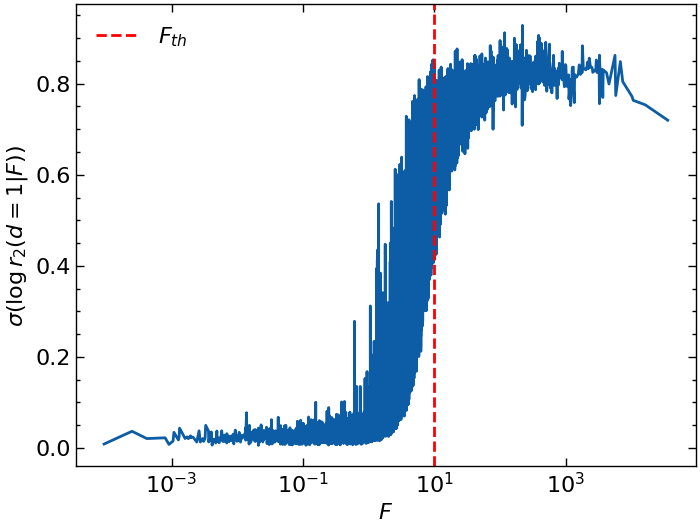

In [13]:
plt.semilogx(
    10**log10f[log10f.argsort()], 
    torch.sigmoid(logr2_1[log10f.argsort()])
);
plt.xlabel(r'$F$')
plt.ylabel(r'$\sigma( \log r_2(d=1| F))$')
plt.axvline(10, c='r', ls='--', label=r"$F_{th}$")
plt.legend();

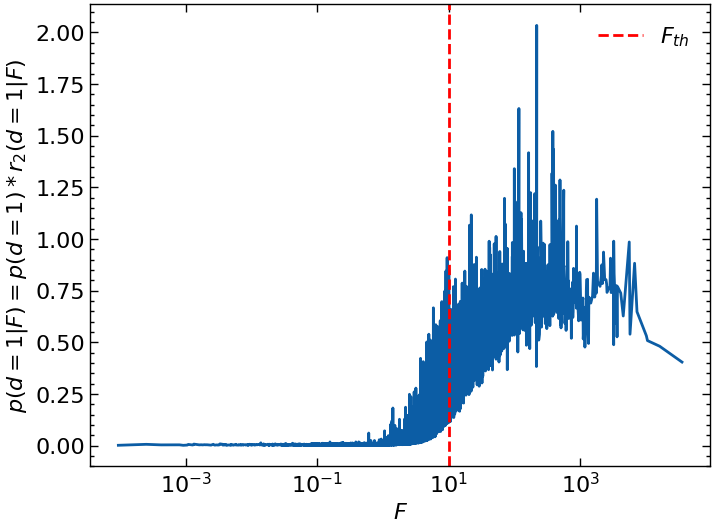

In [14]:
plt.semilogx(
    10**log10f[log10f.argsort()], 
    prior_d1*(logr2_1.exp()[log10f.argsort()])
);
plt.xlabel(r'$F$')
plt.ylabel(r'$p(d=1|F) = p(d=1) *r_2(d=1| F)$')
plt.axvline(10, c='r', ls='--', label=r"$F_{th}$")
plt.legend();

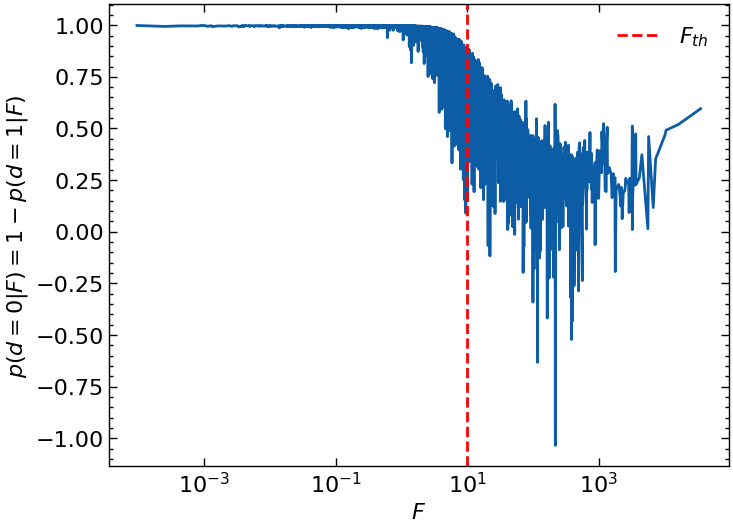

In [15]:
plt.semilogx(
    10**log10f[log10f.argsort()], 
    1 - prior_d1*(logr2_1.exp()[log10f.argsort()])
);
plt.xlabel(r'$F$')
plt.ylabel(r'$p(d=0|F) = 1 - p(d=1|F)$')
plt.axvline(10, c='r', ls='--', label=r"$F_{th}$")
plt.legend();

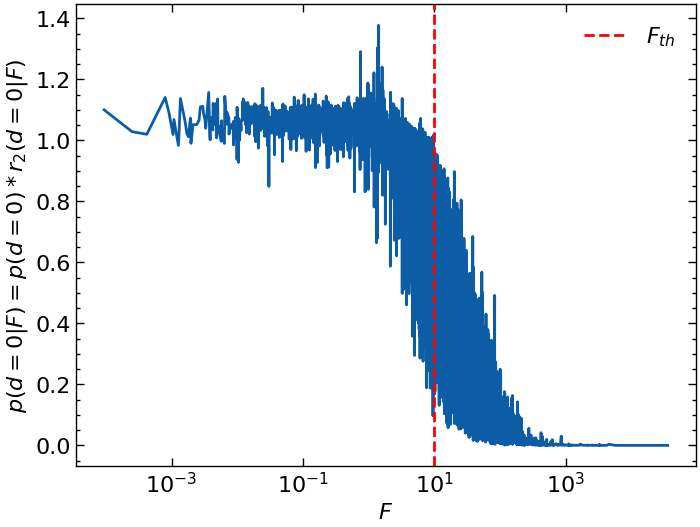

In [16]:
plt.semilogx(
    10**log10f[log10f.argsort()], 
    prior_d0*(logr2_0.exp()[log10f.argsort()])
);
plt.xlabel(r'$F$')
plt.ylabel(r'$p(d=0|F) = p(d=0) *r_2(d=0| F)$')
plt.axvline(10, c='r', ls='--', label=r"$F_{th}$")
plt.legend();

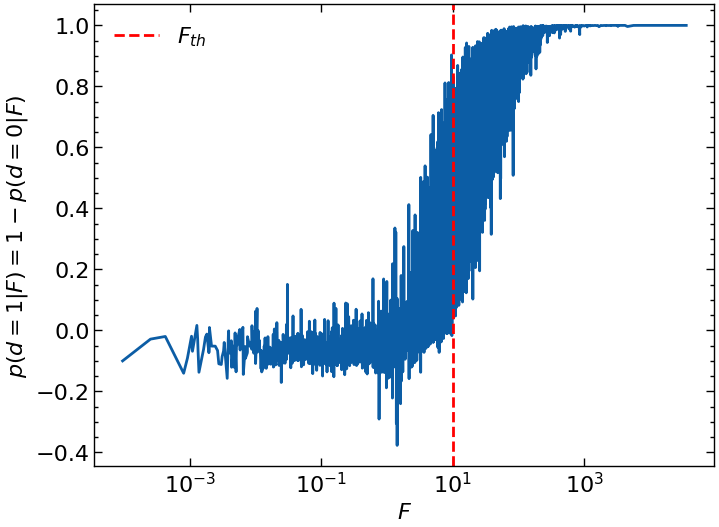

In [17]:
plt.semilogx(
    10**log10f[log10f.argsort()], 
    1 - prior_d0*(logr2_0.exp()[log10f.argsort()])
);
plt.xlabel(r'$F$')
plt.ylabel(r'$p(d=1|F) = 1 - p(d=0|F)$')
plt.axvline(10, c='r', ls='--', label=r"$F_{th}$")
plt.legend();

\begin{equation}
    A = \frac{p(d=1|F)}{p(d=0|F)} = \frac{r(d=1;F) p(d=1)}{r(d=0;F)p(d=0)}
\end{equation}

\begin{equation}
    p(d=1|F) = \sigma(\log(A))
\end{equation}

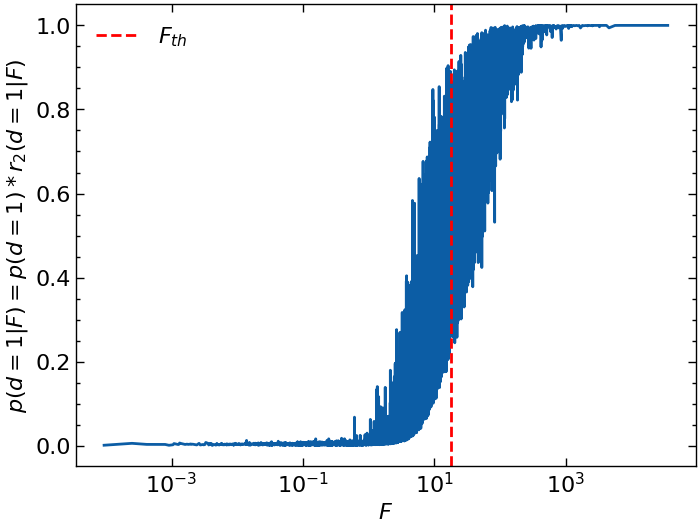

In [18]:
plt.semilogx(
    10**log10f[log10f.argsort()], 
    torch.sigmoid(((prior_d1*logr2_1.exp())/(prior_d0*logr2_0.exp())).log()) [log10f.argsort()]
);
plt.xlabel(r'$F$')
plt.ylabel(r'$p(d=1|F) = p(d=1) *r_2(d=1| F)$')
plt.axvline(17.8, c='r', ls='--', label=r"$F_{th}$")
# plt.axhline(0.5, c='r', ls='--')
plt.legend();